# Trajectory Recommendation using RankSVM and Structured Prediction

<a id='toc'></a>

[Table of Contents](#toc)
1. [Preprocess Dataset](#sec1)
  1. [Load Data](#sec1.1)
  1. [Utility Functions](#sec1.2)
1. [POI Ranking](#sec2)
  1. [POI Features for Ranking](#sec2.1)
  1. [Training DataFrame](#sec2.2)
  1. [Test DataFrame](#sec2.3)
  1. [Ranking POIs using rankSVM](#sec2.4)
1. [Structured Prediction](#sec3)
  1. [Structured Predition using PyStruct](#sec3.1)
  1. [Node Features](#sec3.2)
  1. [Edge Features](#sec3.3)
  1. [Leave-one-out Evaluation](#sec3.4)

<a id='sec1'></a>

# 1. Preprocess Dataset

In [1]:
% matplotlib inline

import os, sys, time, pickle, tempfile
import math, random, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.misc import logsumexp

import seaborn as sns

from sklearn.cluster import KMeans
from scipy.linalg import kron

from pystruct.models import EdgeFeatureGraphCRF
from pystruct.learners import OneSlackSSVM

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [3]:
data_dir = 'data/data-cikm16'
dat_suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']
dat_types = ['all']

In [4]:
dat_ix = 1
type_ix = 0

In [5]:
noloop = True  # trajectories dataset with loop or not

In [6]:
uspecific = False  # user specific training/prediction or not

Hyperparameters.

In [7]:
KX = 100  # KX folds in user specific setting [100, 50, 20, 10, 8, 4, 2, 1]

In [8]:
C = 1  # regularization parameter of SSVM

In [9]:
BIN_CLUSTER = 5  # discritization parameter

Method switches.

In [10]:
run_crf = True

Generate results filenames.

In [11]:
def gen_fname(dat_ix, type_ix, noloop, uspecific, C, KX):
    assert(0 <= dat_ix < len(dat_suffix))
    assert(0 <= type_ix < len(dat_types))
    assert(isinstance(noloop, bool))
    assert(isinstance(uspecific, bool))
    C_str = 'C' + str(C) + '-'
    KX_str = str(KX) + 'X-'
    
    if noloop == True:
        loop_str = 'noloop-'
    else:
        loop_str = ''
    
    type_str = dat_types[type_ix] + '-'
    
    if uspecific == True:
        user_str = 'specific-'
        suffix = KX_str + dat_suffix[dat_ix] + '.pkl'
    else:
        user_str = 'agnostic-'
        suffix = dat_suffix[dat_ix] + '.pkl'
    
    fname = loop_str + type_str + user_str
    fcrf1 = os.path.join(data_dir, 'crf2-' + fname + C_str + suffix)
    return fcrf1

In [12]:
frecdict_crf = gen_fname(dat_ix, type_ix, noloop, uspecific, C, KX)
frecdict_crf

'data/data-cikm16/crf2-noloop-all-agnostic-C1-Glas.pkl'

<a id='sec1.1'></a>

## 1.1 Load Data

In [13]:
fpoi = os.path.join(data_dir, 'poi-' + dat_suffix[dat_ix] + '.csv')

In [14]:
poi_all = pd.read_csv(fpoi)
poi_all.set_index('poiID', inplace=True)
poi_all.head()

,poiCat,poiLon,poiLat
poiID,,,
1,Transport,-4.258101,55.857920
2,Transport,-4.250728,55.861496
4,Transport,-4.595632,55.509388
5,Transport,-4.331517,55.868897
6,Transport,-4.269905,55.856135


In [15]:
if noloop == True:
    ftraj = os.path.join(data_dir, 'traj-noloop-' + dat_types[type_ix] + '-' + dat_suffix[dat_ix] + '.csv')
else:
    ftraj = os.path.join(data_dir, 'traj-' + dat_types[type_ix] + '-' + dat_suffix[dat_ix] + '.csv')

In [16]:
traj_all = pd.read_csv(ftraj)
traj_all.head()

,userID,trajID,poiID,startTime,endTime,#photo,trajLen,poiDuration
0,10063645@N00,1,11,1160716026,1160716026,1,1,0
1,10063645@N00,2,2,1162247008,1162247008,1,1,0
2,10063645@N00,3,11,1162333588,1162333588,1,1,0
3,10063645@N00,4,16,1162693595,1162693595,1,2,0
4,10063645@N00,4,21,1162693817,1162693829,2,2,12


In [17]:
num_user = traj_all['userID'].unique().shape[0]
num_poi = traj_all['poiID'].unique().shape[0]
num_traj = traj_all['trajID'].unique().shape[0]
#assert(num_poi == poi_all.shape[0])
pd.DataFrame({'#user': num_user, '#poi': num_poi, '#traj': num_traj, '#traj/user': num_traj/num_user}, \
             index=[str(dat_suffix[dat_ix])])

,#poi,#traj,#traj/user,#user
Glas,27,2227,3.705491,601


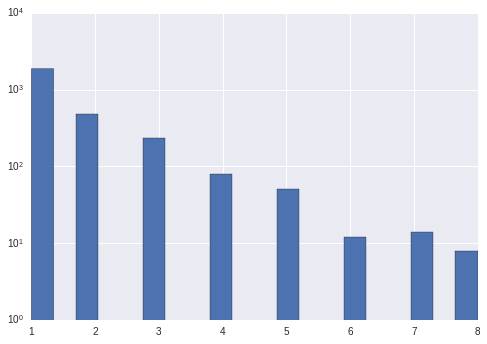

In [18]:
ax = traj_all['trajLen'].hist(bins=20)
ax.set_yscale('log')

Mapping trajectory to user.

In [19]:
traj_user = traj_all[['trajID', 'userID']].copy().groupby('trajID').first()
traj_user.head()

,userID
trajID,
1,10063645@N00
2,10063645@N00
3,10063645@N00
4,10063645@N00
5,10063645@N00


<a id='sec1.2'></a>

## 1.2 Utility Functions

Print computing progress.

In [20]:
def print_progress(cnt, total):
    """Display a progress bar"""
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

Extract trajectory, i.e., a list of POIs.

In [21]:
def extract_traj(tid, traj_all):
    traj = traj_all[traj_all['trajID'] == tid].copy()
    traj.sort_values(by=['startTime'], ascending=True, inplace=True)
    return traj['poiID'].tolist()

Compute POI properties, e.g., popularity, total number of visit, average visit duration.

In [22]:
def calc_poi_info(trajid_list, traj_all, poi_all):
    assert(len(trajid_list) > 0)
    # to allow duplicated trajid
    poi_info = traj_all[traj_all['trajID'] == trajid_list[0]][['poiID', 'poiDuration']].copy() 
    for i in range(1, len(trajid_list)):
        traj = traj_all[traj_all['trajID'] == trajid_list[i]][['poiID', 'poiDuration']]
        poi_info = poi_info.append(traj, ignore_index=True)
    
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiCat'] = poi_all.loc[poi_info.index, 'poiCat']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = traj_all[traj_all['trajID'].isin(trajid_list)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

Compute the F1 score for recommended trajectory.

In [23]:
def calc_F1(traj_act, traj_rec, noloop=False):
    '''Compute recall, precision and F1 for recommended trajectories'''
    assert(isinstance(noloop, bool))
    assert(len(traj_act) > 0)
    assert(len(traj_rec) > 0)
    
    if noloop == True:
        intersize = len(set(traj_act) & set(traj_rec))
    else:
        match_tags = np.zeros(len(traj_act), dtype=np.bool)
        for poi in traj_rec:
            for j in range(len(traj_act)):
                if match_tags[j] == False and poi == traj_act[j]:
                    match_tags[j] = True
                    break
        intersize = np.nonzero(match_tags)[0].shape[0]
        
    recall = intersize / len(traj_act)
    precision = intersize / len(traj_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [24]:
def calc_dist_vec(longitudes1, latitudes1, longitudes2, latitudes2):
    """Calculate the distance (unit: km) between two places on earth, vectorised"""
    # convert degrees to radians
    lng1 = np.radians(longitudes1)
    lat1 = np.radians(latitudes1)
    lng2 = np.radians(longitudes2)
    lat2 = np.radians(latitudes2)
    radius = 6371.0088 # mean earth radius, en.wikipedia.org/wiki/Earth_radius#Mean_radius

    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlng = np.fabs(lng1 - lng2)
    dlat = np.fabs(lat1 - lat2)
    dist =  2 * radius * np.arcsin( np.sqrt( 
                (np.sin(0.5*dlat))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(0.5*dlng))**2 ))
    return dist

Distance between POIs.

In [25]:
POI_DISTMAT = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float), \
                           index=poi_all.index, columns=poi_all.index)

In [26]:
for ix in poi_all.index:
    POI_DISTMAT.loc[ix] = calc_dist_vec(poi_all.loc[ix, 'poiLon'], \
                                        poi_all.loc[ix, 'poiLat'], \
                                        poi_all['poiLon'], \
                                        poi_all['poiLat'])

In [27]:
trajid_set_all = sorted(traj_all['trajID'].unique().tolist())

In [28]:
poi_info_all = calc_poi_info(trajid_set_all, traj_all, poi_all)

Filtering out POI visits with 0 duration.

In [29]:
zero_duration = poi_info_all[poi_info_all['avgDuration'] < 1]
zero_duration

,avgDuration,nVisit,poiCat,poiLon,poiLat,popularity
poiID,,,,,,
4,0.0,1,Transport,-4.595632,55.509388,1
5,0.0,2,Transport,-4.331517,55.868897,2


In [30]:
print(traj_all.shape)
traj_all = traj_all[traj_all['poiID'].isin(set(poi_info_all.index) - set(zero_duration.index))]
print(traj_all.shape)

(2749, 8)
(2746, 8)


Dictionary maps every trajectory ID to the actual trajectory.

In [31]:
traj_dict = dict()

In [32]:
for trajid in trajid_set_all:
    traj = extract_traj(trajid, traj_all)
    assert(trajid not in traj_dict)
    traj_dict[trajid] = traj

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [33]:
QUERY_ID_DICT = dict()  # (start, end, length) --> qid

In [34]:
keys = [(traj_dict[x][0], traj_dict[x][-1], len(traj_dict[x])) \
        for x in sorted(traj_dict.keys()) if len(traj_dict[x]) > 2]
cnt = 0
for key in keys:
    if key not in QUERY_ID_DICT:   # (start, end, length) --> qid
        QUERY_ID_DICT[key] = cnt
        cnt += 1

In [35]:
print('#traj in total:', len(trajid_set_all))
print('#traj (length > 2):', traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0])
print('#query tuple:', len(QUERY_ID_DICT))

#traj in total: 2227
#traj (length > 2): 112
#query tuple: 97


<a id='sec2'></a>

# 2. POI Ranking

<a id='sec2.1'></a>

## 2.1 POI Features for Ranking

POI Features used for ranking:
1. `popularity`: POI popularity, i.e., the number of distinct users that visited the POI
1. `nVisit`: the total number of visit by all users
1. `avgDuration`: average POI visit duration
1. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
1. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
1. `distStart`: distance (haversine formula) from `startPOI`
1. `distEnd`: distance from `endPOI`
1. `seqLen`: trajectory length (copy from query)
1. `diffPopStart`: difference in POI popularity from `startPOI`
1. `diffPopEnd`: difference in POI popularity from `endPOI`
1. `diffNVisitStart`: difference in the total number of visit from `startPOI`
1. `diffNVisitEnd`: difference in the total number of visit from `endPOI`
1. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
1. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`

In [36]:
DF_COLUMNS = ['poiID', 'label', 'queryID', 'popularity', 'nVisit', 'avgDuration', 'sameCatStart', 'sameCatEnd', \
              'distStart', 'distEnd', 'trajLen', 'diffPopStart', 'diffPopEnd', 'diffNVisitStart', 'diffNVisitEnd', \
              'diffDurationStart', 'diffDurationEnd', 'sameClusterStart', 'sameClusterEnd']

~~Features aggregated from a number of trajectories:~~
~~1. Compute POI `popularity` and average visit `duration` using all trajectories from training and querying set,~~
~~1. Use the same features that computed above for the test set, except the distance based features.~~

<a id='sec2.2'></a>

## 2.2 Training DataFrame

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in a specific `query`, excluding the presence as $\text{startPOI}$ or $\text{endPOI}$.
1. for each `query`, the label of all absence POIs from trajectories of that `query` in training set got a label 0.

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [37]:
def gen_train_subdf(poi_id, query_id_set, poi_info, poi_clusters, query_id_rdict):
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    df_ = pd.DataFrame(data=np.zeros((len(query_id_set), len(columns)), dtype=np.float), columns=columns)
    
    pop, nvisit = poi_info.loc[poi_id, 'popularity'], poi_info.loc[poi_id, 'nVisit']
    cat, cluster = poi_info.loc[poi_id, 'poiCat'], poi_clusters.loc[poi_id, 'clusterID'] 
    duration = poi_info.loc[poi_id, 'avgDuration']
    
    for j in range(len(query_id_set)):
        qid = query_id_set[j]
        assert(qid in query_id_rdict) # qid --> (start, end, length)
        (p0, pN, trajLen) = query_id_rdict[qid]
        idx = df_.index[j]
        df_.loc[idx, 'poiID'] = poi_id
        df_.loc[idx, 'queryID'] = qid
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi_id, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi_id, pN]
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
        df_.loc[idx, 'sameClusterStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
        df_.loc[idx, 'sameClusterEnd']   = 1 if cluster == poi_clusters.loc[pN, 'clusterID'] else -1
        
    return df_

In [38]:
def gen_train_df(trajid_list, traj_dict, poi_info, poi_clusters, n_jobs=-1):
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    train_trajs = [traj_dict[x] for x in trajid_list if len(traj_dict[x]) > 2]
    
    qid_set = sorted(set([query_id_dict[(t[0], t[-1], len(t))] for t in train_trajs]))
    poi_set = set()
    for tr in train_trajs:
        poi_set = poi_set | set(tr)
    
    #qid_poi_pair = list(itertools.product(qid_set, poi_set)) # Cartesian product of qid_set and poi_set
    #df_ = pd.DataFrame(data=np.zeros((len(qid_poi_pair), len(columns)), dtype= np.float), columns=columns)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    train_df_list = Parallel(n_jobs=n_jobs)\
                            (delayed(gen_train_subdf)(poi, qid_set, poi_info, poi_clusters, query_id_rdict) \
                             for poi in poi_set)
                        
    assert(len(train_df_list) > 0)
    df_ = train_df_list[0]
    for j in range(1, len(train_df_list)):
        df_ = df_.append(train_df_list[j], ignore_index=True)            
        
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    for t in train_trajs:
        qid = query_id_dict[(t[0], t[-1], len(t))]
        for poi in t[1:-1]:  # do NOT count if the POI is startPOI/endPOI
            df_.loc[(qid, poi), 'label'] += 1

    df_.reset_index(inplace=True)
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

<a id='sec2.3'></a>

## 2.3 Test DataFrame

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$.

In [39]:
def gen_test_df(startPOI, endPOI, nPOI, poi_info, poi_clusters):
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    key = (p0, pN, trajLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    assert(pN in poi_info.index)
    
    df_ = pd.DataFrame(data=np.zeros((poi_info.shape[0], len(columns)), dtype= np.float), columns=columns)
    poi_list = sorted(poi_info.index)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    for i in range(df_.index.shape[0]):
        poi = poi_list[i]
        lon, lat = poi_info.loc[poi, 'poiLon'], poi_info.loc[poi, 'poiLat']
        pop, nvisit = poi_info.loc[poi, 'popularity'], poi_info.loc[poi, 'nVisit']
        cat, cluster = poi_info.loc[poi, 'poiCat'], poi_clusters.loc[poi, 'clusterID']
        duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi 
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_all.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_all.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi, pN]
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
        df_.loc[idx, 'sameClusterStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
        df_.loc[idx, 'sameClusterEnd']   = 1 if cluster == poi_clusters.loc[pN, 'clusterID'] else -1
        
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

Generate a string for a training/test data frame.

In [40]:
def gen_data_str(df_, df_columns=DF_COLUMNS):
    columns = df_columns[1:].copy()  # get rid of 'poiID'
    for col in columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        for j in range(2, len(columns)):
            slist.append(' ')
            slist.append(str(j-1))
            slist.append(':')
            slist.append(str(df_.loc[idx, columns[j]]))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

<a id='sec2.4'></a>

## 2.4 Ranking POIs using rankSVM

RankSVM implementation in [libsvm.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip) or [liblinear.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-1.95.zip), please read `README.ranksvm` in the zip file for installation instructions.

Use [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to convert ranking scores to a probability distribution.

In [41]:
def softmax(x):
    x1 = x.copy()
    x1 -= np.max(x1)  # numerically more stable, REF: http://cs231n.github.io/linear-classify/#softmax
    expx = np.exp(x1)
    return expx / np.sum(expx, axis=0) # column-wise sum

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM with ranking probabilities $P(p_i \lvert (p_s, p_e, len))$ computed using [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [42]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)        
        
    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID'].astype(np.int)
        poi_rank_df.set_index('poiID', inplace=True) # duplicated 'poiID' when evaluating training data
        #poi_rank_df['probability'] = softmax(poi_rank_df['rank'])  # softmax
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

<a id='sec3'></a>

# 3. Structured Prediction

[PyStruct](https://pystruct.github.io/) assumes that [label `y` is a discrete vector](https://pystruct.github.io/intro.html) and [pystruct.learners assume labels `y` are integers starting with `0`](https://github.com/pystruct/pystruct/issues/114), concretely,
- values in label vector $y$ should satisfy $y_i \in Y$, 
  where $Y$ is the **index** of a discrete value space, and the index starts at 0.
- label vector $y$ will be [transformed to one hot encoding (see function `joint_feature()`)](https://github.com/pystruct/pystruct/blob/master/pystruct/models/graph_crf.py).

For example, if labels in training set is `[[1, 2], [0, 4, 9]]`, 
then it will cause an index out of bounds error as pystruct did something like this,
1. construct an discrete value space: 
   - `set([1, 2] + [0, 4, 9]) -> {0, 1, 2, 4, 9}`
   - `size({0, 1, 2, 4, 9}) = 5`
1. convert labels using one hot encoding: 
   - label vector `[1, 2]` will be converted to a matrix of shape $2 \times 5$,
     with cells at `(0, 1), (1, 2)` set to `1` and others set to `0`.
   - label vector `[0, 4, 9]` will be converted to a matrix of shape $3 \times 5$,
     with cells at `(0, 0)`, `(1, 4)`, **`(2, 9)` INDEX_OUT_OF_BOUNDS** set to `1` and others set to `0`.

<a id='sec3.1'></a>

## 3.1 Structured Predition using PyStruct

We will analyse the process of using structured SVM to training a CRF and make preditions on new instances.

Recall that the 1-slack formulation (with margin rescaling) of structured SVM is

\begin{align}
\min_{\mathbf{w}, \xi \ge 0} & \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \xi \\
s.t. \forall(\bar{y}_1, \dots, \bar{y}_n) \in \mathcal{Y}^n: & 
\frac{1}{n} \mathbf{w}^T \sum_{i=1}^n \left( \Psi(x_i, y_i) - \Psi(x_i, \bar{y}_i) \right) \ge 
\frac{1}{n} \sum_{i=1}^n \Delta(y_i, \bar{y}_i) - \xi
\end{align}

Where 
- $\mathbf{w}$ is the parameter vector
- $\Psi(x_i, y_i)$ is the joint feature (vector) related to example $x_i$ and its label $y_i$
- The size of $\mathbf{w}$ is the same as $\Psi(x_i, y_i)$
- $\Delta(\centerdot)$ is the loss function, here we use Hamming loss, i.e., per-variable 0-1 loss, as indicated by function [loss()](https://github.com/pystruct/pystruct/blob/master/pystruct/models/base.py) and [fit()](https://github.com/pystruct/pystruct/blob/master/pystruct/learners/one_slack_ssvm.py).
- $n$ is the total number of training examples, $C$ is the regularisation parameter, $\xi$ is the slack variable


### Basics

Before introducing the training and prediction procedure, we define some concepts that will be used later.
- `n_states`: #states for all variables, (this is the total number of unique POIs in training set here).
- `n_features`: #features per node, (this is the number of POI features, i.e., the ranking probabilities of all POIs).
- `n_edges`: #edges in each training/test example, (this is the number of POIs in a trajectory).
- `n_edge_features`: #features per edge, (this is the number of features for each transition, 
   i.e., the out-going transition probabilities to all POIs).
- $x$ is made up of three parts: (`node_features`, `edges`, `edge_features`).
- `node_features`: `n_nodes` $\times$ `n_features`
- `edge_features`: `n_edges` $\times$ `n_edge_features`
- `edges`: `n_edges` $\times$ $2$, e.g. for trajectory `[3, 1, 2]` and `[5, 9, 6]`, their `edges` are the same matrix
   `[[0, 1], [1, 2]]`.

For [EdgeFeatureGraphCRF](https://pystruct.github.io/generated/pystruct.models.EdgeFeatureGraphCRF.html), the pairwise potentials are asymmetric and shared over all edges, and the size of 
- **Parameter vector $\mathbf{w}$: `n_states` $\times$ `n_features` $+$ `n_edge_features` $\times$ `(n_states)`$^2$**
- The first part of $\mathbf{w}$, let's call it **`unary_params`**: `n_states` $\times$ `n_features`, is the parameters 
  used to compute unary potentials.
- The second part of $\mathbf{w}$, let's call it **`pairwise_params`**: `n_edge_features` $\times$ `(n_states)`$^2$, 
  is the parameters used to compute pairwise potentials. 

### Training

#### Compute the joint feature vector $\Psi(x, y)$

When training a CRF using [OneSlackSSVM](https://pystruct.github.io/generated/pystruct.learners.OneSlackSSVM.html), we need to compute the joint feature vector $\Psi(x, y)$ for each training example, it is computed 
(for EdgeFeatureGraphCRF in PyStruct) as follows:

**Unary part of $\Psi(x, y)$**:
- make one-hot encoding of $y$, its size: `n_nodes` $\times$ `n_states`
- *value*: $y^T \times$ `node_features`
- *dimension*: `(n_nodes` $\times$ `n_states)`$^T$ $\times$ `(n_nodes` $\times$ `n_features)` 
  $\to$ `(n_states` $\times$ `n_features)`

**Pairwise Part of $\Psi(x, y)$**:
- make one-hot encoding of `edges`, its size: `n_edges` $\times$ `(n_states)`$^2$
- *value*: `edge_features` $\times$ `edges`
- *dimension*: `(n_edges` $\times$ `n_edge_features)`$^T$ $\times$ `(n_edges` $\times$ `(n_states)`$^2$

Then for each training example, $\Psi(x_i, y_i)$ = `[unary part, pairwise part]`, solve the above QP problem (1-slack formulation) to get a parameter vector $\mathbf{w}$.

### Prediction

As a trajectory is chain structured, so we use `max-product` belief propagation (Viterbi algorithm in this case) to do inference in the trained CRF.  
To predict the label of a new instance $x$, we need to compute the unary potential and pairwise potential of $x$.

**Unary potential:** 
- *value*: `node_features` $\times$ `(unary_params)`$^T$ (first part of $\mathbf{w}$)
- *dimension*: `(n_nodes` $\times$ `n_features)` $\times$ `(n_states` $\times$ `n_features)`$^T$ $\to$ 
  `(n_nodes` $\times$ `n_states)`

**Pairwise potential:**
- *value*: `edge_features` $\times$ `pairwise_params` (second part of $\mathbf{w}$)
- *dimension*: `(n_edges` $\times$ `n_edge_features)` $\times$ `(n_edge_features` $\times$ `n_states`$^2$ `)`, 
  reshape to `(n_edges` $\times$ `n_states` $\times$ `n_states)`

With unary potential and pairwise potential computed, as we could know from `edges` that our example $x$ is chain structured, so we do inference using Viterbi algorithm to compute the most likely label of $x$.

<a id='sec3.2'></a>

## 3.2 Node Features -- POI Ranking Probabilities

For a trajectory `[start, ..., end]`, the features used to train/test are 
1. feature for POI `start` is a binary vector of size `total_number_of_POIs`, 
   with `1` at the location corresponds to POI `start` and `0` anywhere else, e.g. one hot encoding.
1. feature for POI `end` is simliar, with `1` at the location corresponds to POI `end`.
1. features for other POIs in the trajectory are the ranking probabilities 
   (produced by rankSVM, transformed by softmax) of all POIs,
   i.e. features of different POIs in the middle (i.e. not the `start` or `end`) are the same.

Need to build a mapping for POIs: *POI_ID $\to$ POI_INDEX* with POIs in trajectories in training set, also a map of the reverse direction.

<a id='sec3.3'></a>

## 3.3 Edge Features -- Factorised Transition Probabilities between POIs

Estimate a transition matrix for each feature of POI, transition probabilities (matrix) between different POI features (vector) is obtrained by the Kronecker product of the individual transition matrix corresponding to each feature.

### 3.3.1 POI Features for Factorisation

POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
- Category of POI
- Popularity of POI (discritize with uniform log-scale bins, #bins <=5 )
- The number of POI visits (discritize with uniform log-scale bins, #bins <=5 )
- The average visit duration of POI (discritise with uniform log-scale bins, #bins <= 5)
- The neighborhood relationship between POIs (clustering POI(lat, lon) using k-means, #clusters <= 5)

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a number $k=1$.

In [43]:
def normalise_transmat(transmat_cnt):
    transmat = transmat_cnt.copy()
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        rowsum = np.sum(transmat.iloc[row] + 1)
        assert(rowsum > 0)
        transmat.iloc[row] = (transmat.iloc[row] + 1) / rowsum
    return transmat

POIs in training set.

In [44]:
poi_train = sorted(poi_info_all.index)

### 3.3.2 Transition Matrix between POI Cateogries

In [45]:
poi_cats = poi_all.loc[poi_train, 'poiCat'].unique().tolist()
poi_cats.sort()
poi_cats

['Education',
 'Museum',
 'Park',
 'Religion',
 'Shopping',
 'Structure',
 'Transport']

In [46]:
def gen_transmat_cat(trajid_list, traj_dict, poi_info, poi_cats=poi_cats):
    transmat_cat_cnt = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    columns=poi_cats, index=poi_cats)
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                cat1 = poi_info.loc[p1, 'poiCat']
                cat2 = poi_info.loc[p2, 'poiCat']
                transmat_cat_cnt.loc[cat1, cat2] += 1
    return normalise_transmat(transmat_cat_cnt)

In [47]:
gen_transmat_cat(trajid_set_all, traj_dict, poi_info_all)

,Education,Museum,Park,Religion,Shopping,Structure,Transport
Education,0.285714,0.178571,0.008929,0.062500,0.178571,0.178571,0.107143
Museum,0.097561,0.227642,0.024390,0.040650,0.195122,0.162602,0.252033
Park,0.100000,0.200000,0.100000,0.100000,0.100000,0.200000,0.200000
Religion,0.151515,0.121212,0.060606,0.090909,0.060606,0.303030,0.212121
Shopping,0.254902,0.235294,0.019608,0.049020,0.019608,0.127451,0.294118
Structure,0.296296,0.098765,0.012346,0.037037,0.086420,0.222222,0.246914
Transport,0.137615,0.357798,0.009174,0.073394,0.238532,0.128440,0.055046


### 3.3.3 Transition Matrix between POI Popularity Classes

In [48]:
poi_pops = poi_info_all.loc[poi_train, 'popularity']
#sorted(poi_pops.unique().tolist())

Discretize POI popularity with uniform log-scale bins.

In [49]:
expo_pop1 = np.log10(max(1, min(poi_pops)))
expo_pop2 = np.log10(max(poi_pops))
print(expo_pop1, expo_pop2)

0.0 2.25767857487


In [50]:
nbins_pop = BIN_CLUSTER
logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins_pop+1)
logbins_pop[0] = 0  # deal with underflow
if uspecific == True:
    logbins_pop[-1] = KX * logbins_pop[-1]  # deal with overflow
if logbins_pop[-1] < poi_info_all['popularity'].max():
    logbins_pop[-1] = poi_info_all['popularity'].max() + 1
logbins_pop

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

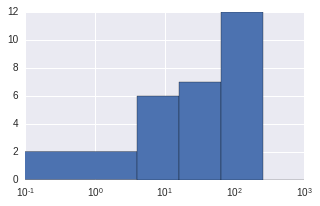

In [51]:
ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [52]:
def gen_transmat_pop(trajid_list, traj_dict, poi_info, logbins_pop=logbins_pop):
    nbins = len(logbins_pop) - 1
    transmat_pop_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                    columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                pop1 = poi_info.loc[p1, 'popularity']
                pop2 = poi_info.loc[p2, 'popularity']
                pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
                transmat_pop_cnt.loc[pc1, pc2] += 1
    return normalise_transmat(transmat_pop_cnt), logbins_pop

In [53]:
gen_transmat_pop(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.055556,0.333333,0.055556,0.500000,0.055556
3,0.014925,0.029851,0.089552,0.850746,0.014925
4,0.002217,0.019956,0.119734,0.855876,0.002217
5,0.200000,0.200000,0.200000,0.200000,0.200000


### 3.3.4 Transition Matrix between the Number of POI Visit Classes

In [54]:
poi_visits = poi_info_all.loc[poi_train, 'nVisit']
#sorted(poi_visits.unique().tolist())

Discretize the number of POI visit with uniform log-scale bins.

In [55]:
expo_visit1 = np.log10(max(1, min(poi_visits)))
expo_visit2 = np.log10(max(poi_visits))
print(expo_visit1, expo_visit2)

0.0 2.44560420327


In [56]:
nbins_visit = BIN_CLUSTER
logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins_visit+1)
logbins_visit[0] = 0  # deal with underflow
if uspecific == True:
    logbins_visit[-1] = KX * logbins_visit[-1]  # deal with overflow
if logbins_visit[-1] < poi_info_all['nVisit'].max():
    logbins_visit[-1] = poi_info_all['nVisit'].max() + 1
logbins_visit

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

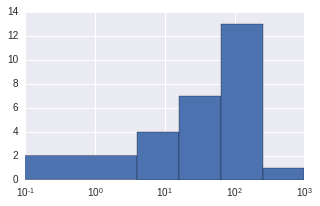

In [57]:
ax = pd.Series(poi_visits).hist(figsize=(5, 3), bins=logbins_visit)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [58]:
def gen_transmat_visit(trajid_list, traj_dict, poi_info, logbins_visit=logbins_visit):
    nbins = len(logbins_visit) - 1
    transmat_visit_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                      columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                visit1 = poi_info.loc[p1, 'nVisit']
                visit2 = poi_info.loc[p2, 'nVisit']
                vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
                transmat_visit_cnt.loc[vc1, vc2] += 1
    return normalise_transmat(transmat_visit_cnt), logbins_visit

In [59]:
gen_transmat_visit(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.066667,0.066667,0.266667,0.533333,0.066667
3,0.025641,0.076923,0.076923,0.743590,0.076923
4,0.002387,0.011933,0.085919,0.744630,0.155131
5,0.014706,0.014706,0.029412,0.926471,0.014706


### 3.3.5 Transition Matrix between POI Average Visit Duration Classes

In [60]:
poi_durations = poi_info_all.loc[poi_train, 'avgDuration']
#sorted(poi_durations.unique().tolist())

In [61]:
expo_duration1 = np.log10(max(1, min(poi_durations)))
expo_duration2 = np.log10(max(poi_durations))
print(expo_duration1, expo_duration2)

0.0 3.44236216438


In [62]:
nbins_duration = BIN_CLUSTER
logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins_duration+1)
logbins_duration[0] = 0  # deal with underflow
if uspecific == True:
    logbins_duration[-1] = KX * logbins_duration[-1]  # deal with overflow
else:
    logbins_duration[-1] = np.power(10, expo_duration2+2)
logbins_duration

array([  0.00000000e+00,   6.30957344e+00,   3.98107171e+01,
         2.51188643e+02,   1.58489319e+03,   2.76925000e+05])

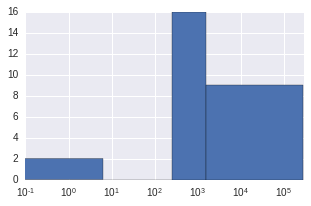

In [63]:
ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [64]:
def gen_transmat_duration(trajid_list, traj_dict, poi_info, logbins_duration=logbins_duration):
    nbins = len(logbins_duration) - 1
    transmat_duration_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                         columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                d1 = poi_info.loc[p1, 'avgDuration']
                d2 = poi_info.loc[p2, 'avgDuration']
                dc1, dc2 = np.digitize([d1, d2], logbins_duration)
                transmat_duration_cnt.loc[dc1, dc2] += 1
    return normalise_transmat(transmat_duration_cnt), logbins_duration

In [65]:
gen_transmat_duration(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.200000,0.200000,0.200000,0.200000,0.200000
3,0.200000,0.200000,0.200000,0.200000,0.200000
4,0.002591,0.002591,0.002591,0.735751,0.256477
5,0.006897,0.006897,0.006897,0.710345,0.268966


### 3.3.6 Transition Matrix between POI Neighborhood Classes

KMeans in scikit-learn seems unable to use custom distance metric and no implementation of [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance), use Euclidean distance to approximate.

In [66]:
X = poi_all.loc[poi_train, ['poiLon', 'poiLat']]
nclusters = BIN_CLUSTER

In [67]:
kmeans = KMeans(n_clusters=nclusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [68]:
clusters = kmeans.predict(X)
#clusters
POI_CLUSTERS = pd.DataFrame(data=clusters, index=poi_train)
POI_CLUSTERS.index.name = 'poiID'
POI_CLUSTERS.rename(columns={0:'clusterID'}, inplace=True)
POI_CLUSTERS['clusterID'] = POI_CLUSTERS['clusterID'].astype(np.int)
#POI_CLUSTERS

Scatter plot of POI coordinates with clustering results.

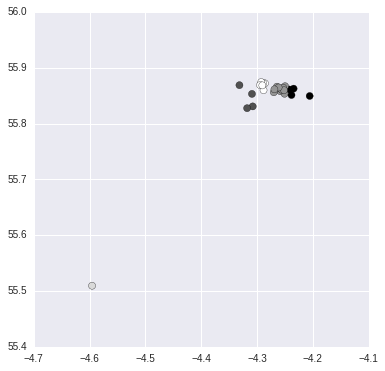

In [69]:
diff = poi_all.loc[poi_train, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train, ['poiLon', 'poiLat']].min()
ratio = diff['poiLon'] / diff['poiLat']
#ratio
height = 6; width = int(round(ratio)*height)
plt.figure(figsize=[width, height])
plt.scatter(poi_all.loc[poi_train, 'poiLon'], poi_all.loc[poi_train, 'poiLat'], c=clusters, s=50)

In [70]:
def gen_transmat_neighbor(trajid_list, traj_dict, poi_info, poi_clusters=POI_CLUSTERS):
    nclusters = len(poi_clusters['clusterID'].unique())
    transmat_neighbor_cnt = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                         columns=np.arange(nclusters), index=np.arange(nclusters))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                c1 = poi_clusters.loc[p1, 'clusterID']
                c2 = poi_clusters.loc[p2, 'clusterID']
                transmat_neighbor_cnt.loc[c1, c2] += 1
    return normalise_transmat(transmat_neighbor_cnt), poi_clusters

In [71]:
gen_transmat_neighbor(trajid_set_all, traj_dict, poi_info_all)[0]

,0,1,2,3,4
0,0.673469,0.006803,0.251701,0.034014,0.034014
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.084302,0.002907,0.848837,0.005814,0.058140
3,0.285714,0.071429,0.142857,0.428571,0.071429
4,0.138889,0.027778,0.638889,0.027778,0.166667


### 3.3.7 Transition Matrix between POIs

Approximate transition probabilities (matrix) between different POI features (vector) using the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of individual transition matrix corresponding to each feature, i.e., POI category, POI popularity (discritized), POI average visit duration (discritized) and POI neighborhoods (clusters).

Deal with features without corresponding POIs and feature with more than one corresponding POIs. (*Before Normalisation*)
- For features without corresponding POIs, just remove the rows and columns from the matrix obtained by Kronecker product.
- For different POIs with the exact same feature, 
  - Let POIs with the same feature as a POI group,
  - The *incoming* **transition value (i.e., unnormalised transition probability)** of this POI group 
    should be divided uniformly among the group members, 
    *which corresponds to choose a group member uniformly at random in the incoming case*.
  - The *outgoing* transition value should be duplicated (i.e., the same) among all group members, 
    **as we were already in that group in the outgoing case**.
  - For each POI in the group, the allocation transition value of the *self-loop of the POI group* is similar to 
    that in the *outgoing* case, **as we were already in that group**, so just duplicate and then divide uniformly among 
    the transitions from this POI to other POIs in the same group, 
    *which corresponds to choose a outgoing transition uniformly at random from all outgoing transitions
    excluding the self-loop of this POI*.
- **Concretely**, for a POI group with $n$ POIs, 
    1. If the *incoming* transition value of POI group is $m_1$,
       then the corresponding *incoming* transition value for each group member is $\frac{m_1}{n}$.
    1. If the *outgoing* transition value of POI group is $m_2$,
       then the corresponding *outgoing* transition value for each group member is also $m_2$.
    1. If the transition value of *self-loop of the POI group* is $m_3$,
       then transition value of *self-loop of individual POIs* should be $0$,  
       and *other in-group transitions* with value $\frac{m_3}{n-1}$
       as the total number of outgoing transitions to other POIs in the same group is $n-1$ (excluding the self-loop),
       i.e. $n-1$ choose $1$.
       
**NOTE**: execute the above division before or after row normalisation will lead to the same result, *as the division itself does NOT change the normalising constant of each row (i.e., the sum of each row before normalising)*.

In [72]:
def gen_poi_transmat(trajid_list, poi_set, traj_dict, poi_info, debug=False):
    transmat_cat                        = gen_transmat_cat(trajid_list, traj_dict, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(trajid_list, traj_dict, poi_info)
    transmat_visit,    logbins_visit    = gen_transmat_visit(trajid_list, traj_dict, poi_info)
    transmat_duration, logbins_duration = gen_transmat_duration(trajid_list, traj_dict, poi_info)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(trajid_list, traj_dict, poi_info)

    # Kronecker product
    transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                         transmat_duration.index, transmat_neighbor.index))
    transmat_value = transmat_cat.values
    for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
        transmat_value = kron(transmat_value, transmat.values)
    transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
    
    poi_train = sorted(poi_set)
    feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    poi_features = pd.DataFrame(data=np.zeros((len(poi_train), len(feature_names))), \
                                columns=feature_names, index=poi_train)
    poi_features.index.name = 'poiID'
    poi_features['poiCat'] = poi_info.loc[poi_train, 'poiCat']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_train, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_train, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_train, 'avgDuration'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_train, 'clusterID']
    
    # shrink the result of Kronecker product and deal with POIs with the same features
    poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train), len(poi_train)), dtype=np.float), \
                                   columns=poi_train, index=poi_train)
    for p1 in poi_logtransmat.index:
        rix = tuple(poi_features.loc[p1])
        for p2 in poi_logtransmat.columns:
            cix = tuple(poi_features.loc[p2])
            value_ = transmat_feature.loc[(rix,), (cix,)]
            poi_logtransmat.loc[p1, p2] = value_.values[0, 0]
    
    # group POIs with the same features
    features_dup = dict()
    for poi in poi_features.index:
        key = tuple(poi_features.loc[poi])
        if key in features_dup:
            features_dup[key].append(poi)
        else:
            features_dup[key] = [poi]
    if debug == True:
        for key in sorted(features_dup.keys()):
            print(key, '->', features_dup[key])
            
    # deal with POIs with the same features
    for feature in sorted(features_dup.keys()):
        n = len(features_dup[feature])
        if n > 1:
            group = features_dup[feature]
            v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
            
            # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
            for poi in group:
                poi_logtransmat[poi] /= n
                
            # outgoing transition value has already been duplicated (value copied above)
            
            # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
            # from a POI to all other POIs in the same group (excluding POI self-loop)
            v2 = v1 / (n - 1)
            for pair in itertools.permutations(group, 2):
                poi_logtransmat.loc[pair[0], pair[1]] = v2
                            
    # normalise each row
    for p1 in poi_logtransmat.index:
        poi_logtransmat.loc[p1, p1] = 0
        rowsum = poi_logtransmat.loc[p1].sum()
        assert(rowsum > 0)
        logrowsum = np.log10(rowsum)
        for p2 in poi_logtransmat.columns:
            if p1 == p2:
                poi_logtransmat.loc[p1, p2] = -np.inf  # deal with log(0) explicitly
            else:
                poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum
    
    poi_transmat = np.power(10, poi_logtransmat)
    return poi_transmat

In [73]:
transmat_ = gen_poi_transmat(trajid_set_all, set(poi_info_all.index), traj_dict, poi_info_all, debug=True)

('Education', 2, 2, 4, 2) -> [8]
('Education', 3, 3, 5, 4) -> [7]
('Education', 3, 4, 4, 0) -> [9]
('Education', 4, 4, 4, 0) -> [10]
('Education', 4, 4, 4, 2) -> [12]
('Education', 4, 4, 5, 2) -> [11]
('Museum', 2, 2, 5, 3) -> [17]
('Museum', 3, 3, 4, 0) -> [25]
('Museum', 4, 4, 4, 2) -> [21]
('Museum', 4, 4, 5, 0) -> [26]
('Park', 2, 2, 4, 4) -> [18]
('Park', 3, 3, 4, 4) -> [22]
('Religion', 2, 2, 4, 2) -> [14]
('Religion', 4, 4, 5, 4) -> [13]
('Shopping', 4, 4, 4, 0) -> [15]
('Shopping', 4, 4, 4, 2) -> [16]
('Structure', 2, 3, 5, 3) -> [24, 27]
('Structure', 3, 3, 4, 2) -> [29]
('Structure', 3, 4, 5, 0) -> [19]
('Structure', 4, 4, 4, 2) -> [20, 28]
('Transport', 1, 1, 1, 1) -> [4]
('Transport', 1, 1, 1, 3) -> [5]
('Transport', 3, 3, 4, 2) -> [6]
('Transport', 4, 4, 5, 2) -> [1]
('Transport', 4, 5, 4, 2) -> [2]


<a id='sec3.4'></a>

## 3.4 Leave-one-out Evaluation

Train an [EdgeFeatureGraphCRF](https://pystruct.github.io/generated/pystruct.models.EdgeFeatureGraphCRF.html) using [OneSlackSSVM](https://pystruct.github.io/generated/pystruct.learners.OneSlackSSVM.html#pystruct.learners.OneSlackSSVM):
- Node features: POI ranking probabilities
- Edge features: Outgoing POI transition probabilities

In [74]:
def gen_features(startPOI, endPOI, nPOI, rank_df, transmat_mapped, poi_ix, poi_id_dict):
    assert(len(poi_ix) == transmat_mapped.shape[0] == transmat_mapped.shape[1])
    assert(startPOI in poi_id_dict and startPOI in poi_ix)
    assert(endPOI   in poi_id_dict and endPOI   in poi_ix)
    assert(nPOI > 2)
    p0, pN, L = startPOI, endPOI, nPOI
    
    # node features
    # (traj_length - 2) x (total number of POIs in trajectories with length >= 3)
    featuremat = np.tile(softmax(rank_df.loc[poi_ix, 'rank']), (L-2, 1)) # without start/end
    node_s = np.zeros(len(poi_ix), dtype=np.float)
    node_e = np.zeros(len(poi_ix), dtype=np.float)
    node_s[poi_id_dict[p0]] = 1
    node_e[poi_id_dict[pN]] = 1
    node_features = np.vstack([node_s, featuremat, node_e])
    
    # edge features
    #s_ix = np.argmax(p0 == np.array(poi_ix))
    #e_ix = np.argmax(pN == np.array(poi_ix))
    #edge_s = np.zeros_like(transmat_mapped) 
    #edge_e = np.zeros_like(transmat_mapped)
    #edge_s[s_ix] = transmat_mapped[s_ix];    edge_s = edge_s.flatten()
    #edge_e[e_ix] = transmat_mapped[:, e_ix]; edge_e = edge_e.flatten()
    #edge_features = np.vstack([edge_s, np.tile(transmat_mapped.flatten(), (len(tr)-3, 1)), edge_e])
    s0 = np.zeros(transmat_mapped.shape[0])
    sN = np.zeros(transmat_mapped.shape[0])
    s0[poi_id_dict[p0]] = 1
    sN[poi_id_dict[pN]] = 1
    MC_forward  = [s0]   # states of nodes
    #MC_backward = [sN]
    for ei in range(L-3):
        # walk the MC forward, result is a normalised vector as both arguments of np.dot() are normalised (easy to prove)
        MC_forward.append(np.dot(MC_forward[-1], transmat_mapped))
        #MC_backward = [softmax(np.dot(MC_backward[0], transmat_inv))] + MC_backward  # walk the MC backward
    edge_features = np.dot(np.vstack(MC_forward), transmat_mapped)
    #edge_features = np.vstack([edge_features, sN])
    #edge_last = np.log(transmat_mapped[:, poi_id_dict[pN]])
    #edge_last = np.exp(edge_last - logsumexp(edge_last))  # renormalise
    large_prob = 0.6
    small_prob = (1 - large_prob) / (sN.shape[0] - 1)
    edge_last = sN * small_prob; edge_last[poi_id_dict[pN]] = large_prob
    edge_features = np.vstack([edge_features, edge_last])
    #edge_features = np.dot(np.vstack(MC_backward[:-1]), transmat_mapped)       
    #ss = 0.5 * (np.vstack(MC_forward[:-1]) + np.vstack(MC_backward[:-1]))  # remove the last state when computing edges
    #edge_features = np.dot(ss, transmat_mapped)
    
    #r1 = [0.5**x for x in range(L-1)]  # ratios forward
    #r2 = r1.copy(); r2.reverse()       # ratios backward
    #sums = np.array(r1) + np.array(r2)
    #r1 = np.array(r1) / sums           # normalise ratios
    #r2 = np.array(r2) / sums
    #forward  = np.multiply(np.tile(r1, (s0.shape[0], 1)).T, np.vstack(MC_forward[:-1]))
    #backward = np.multiply(np.tile(r2, (sN.shape[0], 1)).T, np.vstack(MC_backward[:-1]))
    #edge_features = np.dot(forward + backward, transmat_mapped)
    
    #edge_features = np.hstack([np.dot(np.vstack(MC_forward[:-1]), transmat_mapped), \
    #                           np.dot(np.vstack(MC_backward[:-1]), transmat_mapped)])
    
    # edges
    edges = np.vstack([np.arange(L-1), np.arange(1, L)]).T  # shape: (n_edges, 2)
    return (node_features, edges, edge_features)    

In [75]:
F1_train_list = []
F1_test = []

In [76]:
if run_crf == True:
    recdict_crf = dict()
    cost = 10
    n_jobs = 4
    cnt = 1
    for i in range(len(trajid_set_all)):
        t0 = time.time()
        tid_ = trajid_set_all[i]
        te = traj_dict[tid_]
        
        # trajectory too short
        if len(te) < 3: continue
            
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        
        assert(len(te) <= poi_info.shape[0])
            
        # build POI_ID <--> POI__INDEX mapping for POIs used to train CRF
        # which means only POIs in traj such that len(traj) >= 3 are included
        poi_set = set()
        for x in trajid_list_train:
            if len(traj_dict[x]) >= 3:
                poi_set = poi_set | set(traj_dict[x])                
        poi_ix = sorted(poi_set)
        poi_id_dict, poi_id_rdict = dict(), dict()
        for idx, poi in enumerate(poi_ix):
            poi_id_dict[poi] = idx
            poi_id_rdict[idx] = poi
            
        # start/end is not in training set
        if not (te[0] in poi_set and te[-1] in poi_set): continue
            
        print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        t1 = time.time()
        
        # POI feature based ranking
        train_df = gen_train_df(trajid_list_train, traj_dict, poi_info, POI_CLUSTERS, n_jobs)
        ranksvm = RankSVM(ranksvm_dir, useLinear=True)
        ranksvm.train(train_df, cost=cost)
        
        t2 = time.time()
               
        poi_transmat = gen_poi_transmat(trajid_list_train, set(poi_ix), traj_dict, poi_info) 
        assert(poi_transmat.shape[0] == poi_transmat.shape[1] == len(poi_ix))
        transmat_mapped = np.zeros_like(poi_transmat)
        for ix in range(len(poi_ix)):  # reorder the transition probabilites according to the order of mapped POIs
            pi = poi_ix[ix]
            for jx in range(len(poi_ix)):
                pj = poi_ix[jx]
                transmat_mapped[ix, jx] = poi_transmat.loc[pi, pj]
        
        t3 = time.time()
            
        # generate training data
        X_train = []
        y_train = []
        train_traj_list = [traj_dict[x] for x in trajid_list_train if len(traj_dict[x]) > 2]
        train_df_list = Parallel(n_jobs=n_jobs)(delayed(gen_test_df)(tr[0], tr[-1], len(tr), poi_info, POI_CLUSTERS) \
                                                for tr in train_traj_list)
        rank_df_list = [ranksvm.predict(tr_df) for tr_df in train_df_list]
        assert(len(train_traj_list) == len(rank_df_list))
        X_train = Parallel(n_jobs=n_jobs)\
                          (delayed(gen_features)\
                           (train_traj_list[x][0], train_traj_list[x][-1], len(train_traj_list[x]), rank_df_list[x], \
                            transmat_mapped, poi_ix, poi_id_dict) for x in range(len(rank_df_list)))
        y_train = [np.array([poi_id_dict[x] for x in tr]) for tr in train_traj_list]
        assert(len(train_traj_list) == len(X_train) == len(y_train))
        #for ix in range(len(X_train)):
        #    print('edge features of', train_traj_list[ix])
        #    print(X_train[ix][2])
        
        #for j in range(len(train_set)):
        #    tr = traj_dict[train_set[j]]
        #    assert(len(tr) >= 3)
        #    tr_df = train_df_list[j]
        #    tr_rank_df = ranksvm.predict(tr_df)
        #    X_train.append(gen_features(tr[0], tr[-1], len(tr), tr_rank_df, transmat_mapped, poi_ix, poi_id_dict))
        #    y_train.append(np.array([poi_id_dict[x] for x in tr]))
        
        t4 = time.time()        
                
        # train
        crf = EdgeFeatureGraphCRF(inference_method='max-product')  # use belief propagation as it is essentially a chain
        #ssvm = OneSlackSSVM(model=crf, C=C, max_iter=maxIter, n_jobs=4) # default: C=1, max_iter=10000, n_jobs=1
        ssvm = OneSlackSSVM(model=crf, C=C) # optimized BLAS libraries, e.g. OpenBLAS/MKL will use all available threads 
        ssvm.fit(X_train, y_train)
        
        t5 = time.time()
        
        # generate test data
        X_test = []
        te_df = gen_test_df(te[0], te[-1], len(te), poi_info, poi_clusters=POI_CLUSTERS)
        te_rank_df = ranksvm.predict(te_df)
        #te_rank_df.set_index('poiID', inplace=True)
        X_test.append(gen_features(te[0], te[-1], len(te), te_rank_df, transmat_mapped, \
                                   poi_ix, poi_id_dict))
        
        # test
        y_pred = ssvm.predict(X_test)
        rec = [poi_id_rdict[x] for x in y_pred[0]] # map POIs back
        rec1 = [te[0]] + rec[1:-1] + [te[-1]]
        F1_test.append(calc_F1(te, rec1))
        
        # test on training set
        #y_pred_train = ssvm.predict(X_train)
        #F1_train = []
        #assert(len(train_set) == len(y_pred_train))
        #for j in range(len(train_set)):
        #    tr = traj_dict[train_set[j]]
        #    F1_train.append(calc_F1(tr, [tr[0]] + [poi_id_rdict[x] for x in y_pred_train[j][1:-1]] + [tr[-1]]))
        #F1_train_list.append(F1_train)
        
        recdict_crf[tid_] = {'REAL':te, 'REC_CRF':rec1} 
        
        t6 = time.time()
        
        print(' '*10, rec)
        print(' '*10, 'rank: %.1f sec, transition: %.1f sec, train_data: %.1f sec, train: %.1f sec, total: %.1f sec' % \
              (t2 - t1, t3 - t2, t4 - t3, t5 - t4, t6 - t0))
        #print(' '*10, 'Train F1: %.3f %.3f, Test F1: %.3f' % (np.mean(F1_train), np.std(F1_train), F1_test[-1]))
        print(' '*10, 'Test F1: %.3f' % F1_test[-1])

[20, 16, 21, 2] #1 ->
           [20, 2, 21, 2]
           rank: 7.8 sec, transition: 2.7 sec, train_data: 15.6 sec, train: 5.4 sec, total: 33.7 sec
           Test F1: 0.750
[13, 21, 2] #2 ->
           [13, 21, 2]
           rank: 7.7 sec, transition: 2.6 sec, train_data: 16.3 sec, train: 4.8 sec, total: 33.7 sec
           Test F1: 1.000
[2, 21, 16] #3 ->
           [2, 21, 16]
           rank: 7.6 sec, transition: 2.7 sec, train_data: 16.6 sec, train: 5.0 sec, total: 34.2 sec
           Test F1: 1.000
[2, 10, 21, 26] #4 ->
           [2, 26, 25, 26]
           rank: 7.4 sec, transition: 2.6 sec, train_data: 15.5 sec, train: 4.8 sec, total: 32.7 sec
           Test F1: 0.500
[28, 2, 13] #5 ->
           [28, 12, 13]
           rank: 7.7 sec, transition: 2.6 sec, train_data: 16.7 sec, train: 4.9 sec, total: 34.3 sec
           Test F1: 0.667
[11, 26, 25, 20, 28] #6 ->
           [11, 28, 11, 12, 28]
           rank: 7.4 sec, transition: 2.6 sec, train_data: 15.4 sec, train: 4.8 sec, 

In [77]:
print('Test: %.3f, %.3f' % (np.mean(F1_test), np.std(F1_test)))

Test: 0.725, 0.174


In [78]:
if run_crf == True:
    print(frecdict_crf)
    pickle.dump(recdict_crf, open(frecdict_crf, 'bw'))

data/data-cikm16/crf2-noloop-all-agnostic-C1-Glas.pkl


In [79]:
#print('Train: %.3f, %.3f' % (np.mean([x for y in F1_train_list for x in y]), \
#                             np.std([x for y in F1_train_list for x in y])))

In [80]:
print('C = %.1f,' % C, dat_suffix[dat_ix])

C = 1.0, Glas


In [81]:
F1 = [calc_F1(recdict_crf[key]['REAL'], recdict_crf[key]['REC_CRF'], noloop=True) for key in sorted(recdict_crf.keys())]

In [82]:
print(np.mean(F1), np.std(F1))

0.725086580087 0.173858048517
